In [1]:
using PyPlot
include("Util.jl")
using .Util;

In [2]:
srand(0);

In [3]:
function run_momentum_steps(A, beta, x, x0, steps=20)
    mu = Float64[]
    for i=1:steps
        (x, x0) = (A * x - beta * x0, x)
        Z = norm(x)
        x = x / Z
        x0 = x0 / Z
        append!(mu, [1 - (u1' * x)[1] ^ 2])
    end
    return x, x0, mu
end

run_momentum_steps (generic function with 2 methods)

In [4]:
function run_best_ball(A; start=randn(size(A)[1]), steps::Int=20, internal_steps=1)
    center = rayleigh_quotient(A, start) ^ 2 / 4
    # center = 1e-2
    search = [2.0 / 3, 0.99, 1, 1.01, 1.5]
    ball = center * search
    prev = 0 * start
    best_beta = Float64[]
    mu = Float64[]
    vectors = rand(steps, size(A)[1])
    
    for s = 1:steps
        v = map(b -> run_momentum_steps(A, b, start, 0. * prev, internal_steps), ball)
        x = map(v -> v[1], v)
        x0 = map(v -> v[2], v)
        q = map(v -> rayleigh_quotient(A, v), x)
        index = indmax(q)
        start = x[index]
        prev = x0[index]
        append!(mu, v[index][3])
        center = ball[index]
        ball = center * search
        append!(best_beta, [center])
        vectors[s, :] = start
    end
    return mu, best_beta, vectors
end

run_best_ball (generic function with 1 method)

In [5]:
function generate_plot(A, steps::Int, start=randn(size(A)[1]); filename1="", filename2="", include_yticks=true, include_legend=true)
    internal_steps = 10
    eigenvalues = sort(abs(eig(A)[1]))
    lambda1 = eigenvalues[end]
    lambda2 = eigenvalues[end - 1]
    A = map(BigFloat, A)
    start = map(BigFloat, start)
    mu, beta, vector = run_best_ball(A; start=start, steps=Int(steps/internal_steps), internal_steps=internal_steps)
    _, _, mu0 = run_momentum_steps(A, 0, start, start, steps)
    opt_beta = (lambda2 / 2) ^ 2
    _, _, mu_opt = run_momentum_steps(A, opt_beta, start, start, steps)
    
    figure(figsize=(3, 2.5))
    
    semilogy(1:steps, mu0, color="red")
    semilogy(1:steps, mu_opt, color="blue")
    semilogy(1:steps, mu, color="green")
    if include_legend
        legend(["PI", "Momentum", "Best Ball"], loc="best", fontsize=10)
    end
    
    xlabel("Number of steps")
    ylim([1e-12, 1])
    if include_yticks
        ylabel(L"1 - (w_t^Tu_1)^2")
        yticks(logspace(0, -12, 5)) 
    else
        ylabel("")
        yticks([])
    end
    xlim([0, steps])
    xticks(linspace(0, steps, 5))
    grid()
    tight_layout()
    
    if filename1 != ""
        savefig(filename1)
    end
    
    
    figure(figsize=(3, 2.5))
    
    plot(1:internal_steps:steps, beta, color="red")
    plot([1, steps], [opt_beta, opt_beta], "--", color="black")
    xlabel("Number of steps")
    ylabel("Beta")
    grid()
    tight_layout()
    
    if filename2 != ""
        savefig(filename2)
    end
    return

end

generate_plot (generic function with 2 methods)

In [6]:
n = 100;

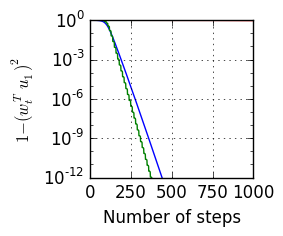

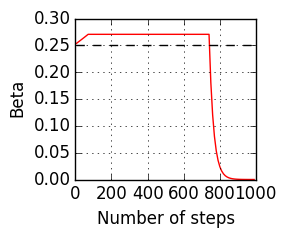

In [7]:
A, u1 = get_random_matrix([1.001; ones(n - 1)])
generate_plot(A, 1000; filename1="Best_Ball_a.pdf", include_legend=false)

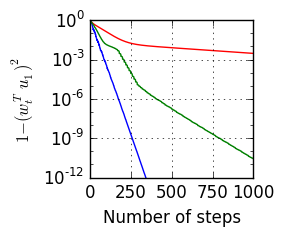

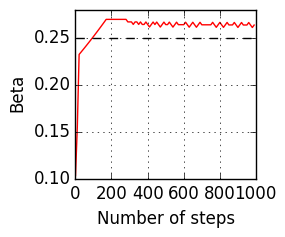

In [8]:
A, u1 = get_random_matrix([1.001; linspace(0, 1, n - 1)])
generate_plot(A, 1000; filename1="Best_Ball_b.pdf", include_legend=false)

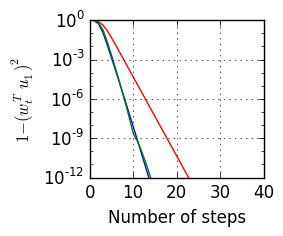

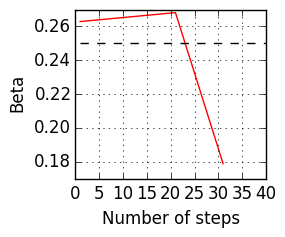

In [9]:
A, u1 = get_random_matrix([2; ones(n - 1)])
generate_plot(A, 40; filename1="Best_Ball_c.pdf", include_legend=false)

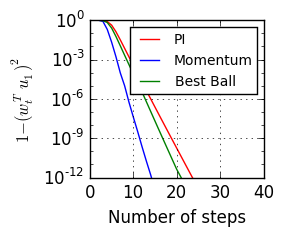

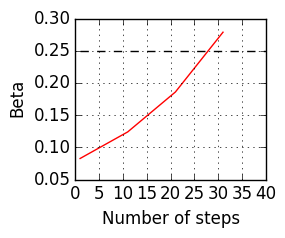

In [10]:
A, u1 = get_random_matrix([2; linspace(0, 1, n - 1)])
generate_plot(A, 40; filename1="Best_Ball_d.pdf")